In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
warnings.filterwarnings('ignore')

import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

C:\Users\Trader\anaconda3\envs\iod_dl\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\Trader\AppData\Local\Temp\ipykernel_7728\2963385244.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
import yfinance as yf
from yahoofinancials import YahooFinancials

In [15]:
nut = yf.download('NTR', 
                      start='2020-01-01', 
                      end='2022-03-30', 
                      progress=False,
)
nut.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,47.439999,47.970001,47.189999,47.910000,43.776474,1057100
2020-01-02,48.380001,48.400002,47.276001,47.330002,43.246510,1004700
2020-01-03,47.000000,47.400002,46.805000,46.849998,42.807919,925800
2020-01-06,46.669998,47.340000,46.389999,47.290001,43.209969,1559400
2020-01-07,47.340000,47.845001,47.150002,47.750000,43.630272,1183500


In [16]:
exxon.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-23,83.339996,84.269997,83.050003,83.129997,83.129997,27716300
2022-03-24,83.459999,84.650002,82.750000,83.379997,83.379997,19871600
2022-03-25,82.919998,85.489998,82.790001,85.199997,85.199997,22398300
2022-03-28,83.169998,83.309998,82.019997,82.809998,82.809998,21552400
2022-03-29,80.809998,82.489998,79.760002,82.370003,82.370003,27036300


In [17]:
type(nut)

pandas.core.frame.DataFrame

In [18]:
df = nut['Close']

In [19]:
df.describe().T

count    566.000000
mean      53.445300
std       16.119368
min       25.100000
25%       39.762500
50%       53.980000
75%       63.482500
max      108.430000
Name: Close, dtype: float64

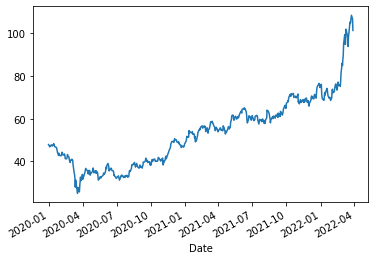

In [20]:
df.plot();

In [21]:
timeseries = nut['Close']

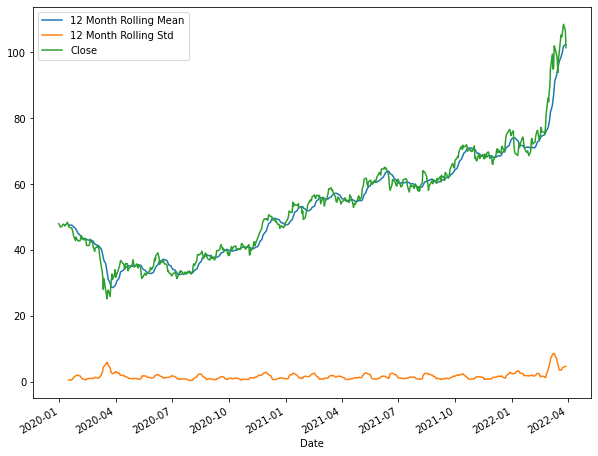

In [22]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot(figsize=(10,8))
plt.legend()

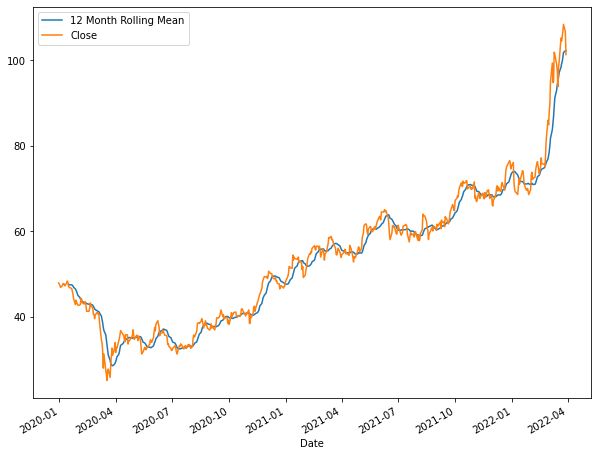

In [24]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot(figsize=(10,8))
plt.legend();

<Figure size 432x288 with 0 Axes>

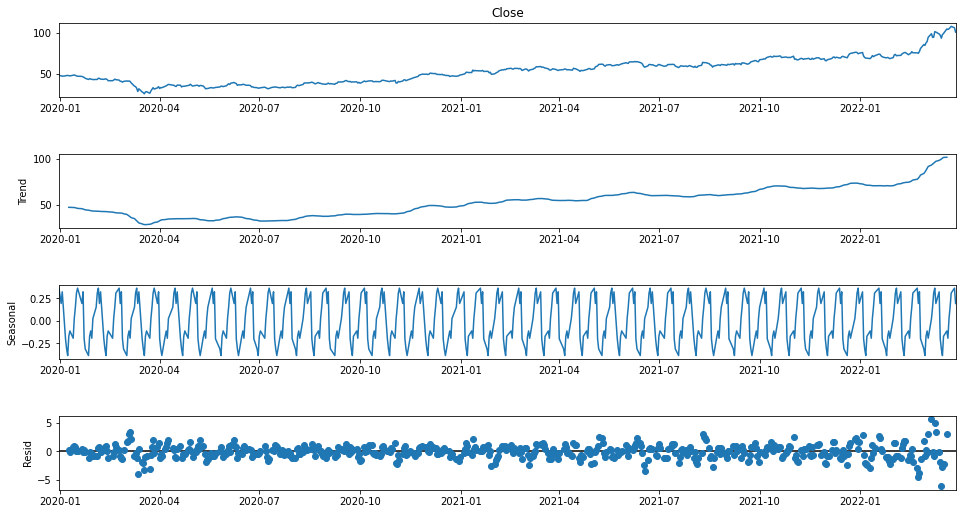

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [29]:
df.head

<bound method NDFrame.head of Date
2019-12-31     47.910000
2020-01-02     47.330002
2020-01-03     46.849998
2020-01-06     47.290001
2020-01-07     47.750000
                 ...    
2022-03-23    105.500000
2022-03-24    106.839996
2022-03-25    108.430000
2022-03-28    106.690002
2022-03-29    101.330002
Name: Close, Length: 566, dtype: float64>

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
result = adfuller(df)

In [32]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : 1.3770823887362516
p-value : 0.9970075029262266
#Lags Used : 0
Number of Observations Used : 565
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [33]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [37]:
exxon['First Difference'] = exxon['Close'] - exxon['Close'].shift(1)

In [41]:
adf_check(exxon['First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -23.721546178490563
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 564
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Date'>

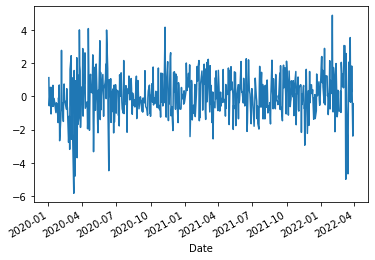

In [42]:
exxon['First Difference'].plot()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)